In [8]:
# PERSONALIZED TELECOM RECOMMENDATION SYSTEM

# @title Step 0: Install and Import Required Libraries (Colab Compatible)
!pip install pandas numpy scikit-learn matplotlib seaborn faker xgboost scipy implicit > /dev/null
#!pip install --upgrade pip setuptools wheel > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from collections import defaultdict
import random
from faker import Faker
from datetime import datetime, timedelta
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
import warnings
warnings.filterwarnings('ignore')

print(" All required libraries installed and imported!")


 All required libraries installed and imported!


In [31]:
# @title Step 1: Generate Synthetic Telecom User Data
# Create realistic synthetic data for 1500 Vi users
np.random.seed(42)
random.seed(42)
fake = Faker('en_IN')

# Define user segments and characteristics
user_segments = [
    "OTT Subscriber", "Family Plan User", "High Value Customer", "Low Value Customer",
    "Business User", "Data-Heavy User", "Night User", "International Roamer",
    "Caller-Tune Enthusiast", "Weekend Data User", "Occasional User", "Student User"
]

# Create user profiles
def generate_telecom_users(n_users=1500):
    users = []

    for i in range(n_users):
        # Basic demographics
        age = random.randint(18, 75)
        is_student = 1 if age < 25 and random.random() > 0.7 else 0

        # Generate usage patterns
        daily_data = max(0.1, np.random.normal(1.5, 1.2))
        daily_calls = max(0, np.random.normal(30, 25))
        night_usage_ratio = np.random.beta(2, 5)  # Most users have low night usage

        # Determine user segment probabilities
        segment_weights = [0.15, 0.1, 0.1, 0.2, 0.08, 0.15, 0.05, 0.04, 0.05, 0.03, 0.03, 0.02]
        segment = np.random.choice(user_segments, p=segment_weights)

        # Set attributes based on segment
        arpu = random.randint(150, 1500)
        ott_usage = random.choice([0, 1])
        monthly_ott_spend = random.randint(0, 299)
        intl_roaming = np.random.beta(1, 10)

        if segment == "OTT Subscriber":
            ott_usage = 1
            monthly_ott_spend = random.randint(99, 499)
        elif segment == "High Value Customer":
            arpu = random.randint(500, 2000)
            daily_data = max(2.0, np.random.normal(3.0, 1.5))
        elif segment == "Low Value Customer":
            arpu = random.randint(100, 299)
            daily_data = max(0.1, np.random.normal(0.5, 0.3))
        elif segment == "Business User":
            daily_calls = max(30, np.random.normal(60, 20))
            intl_roaming = min(1.0, max(0.1, np.random.normal(0.3, 0.2)))
        elif segment == "Night User":
            night_usage_ratio = min(1.0, max(0.5, np.random.normal(0.7, 0.2)))
        elif segment == "International Roamer":
            intl_roaming = min(1.0, max(0.3, np.random.normal(0.6, 0.2)))

        # Generate user record
        user = {
            "user_id": i + 10000,
            "name": fake.name(),
            "age": age,
            "circle": random.choice(["Mumbai", "Delhi", "Kolkata", "Chennai", "Bangalore", "Hyderabad", "Pune"]),
            "connection_type": random.choice(["Prepaid", "Postpaid"]),
            "tenure_months": random.randint(1, 120),
            "arpu": arpu,
            "daily_data_usage_gb": daily_data,
            "daily_call_minutes": daily_calls,
            "night_usage_ratio": night_usage_ratio,
            "sms_count": random.randint(0, 20),
            "preferred_plan_type": random.choice(["Unlimited 5G", "SuperHero", "NonStop Hero", "Data Pack", "OTT Combo"]),
            "current_plan": f"Vi {random.choice(['SuperHero', 'NonStop Hero', 'Hero'])} {random.choice(['299', '399', '499', '698', '999'])}",
            "ott_subscription": random.choice(["JioHotstar", "Amazon Prime", "Netflix", "SonyLIV", "None"]),
            "ott_usage": ott_usage,
            "monthly_ott_spend": monthly_ott_spend,
            "family_plan_members": random.randint(0, 4),
            "international_roaming_freq": intl_roaming,
            "caller_tune_subscribed": 1 if random.random() > 0.7 else 0,
            "responsiveness_to_offers": random.choice([0, 1, 2]),  # 0: Low, 1: Medium, 2: High
            "user_segment": segment,
            "is_student": is_student,
            "last_recharge_date": (datetime.now() - timedelta(days=random.randint(1, 30))).strftime("%Y-%m-%d"),
            "last_recharge_amount": random.choice([199, 249, 299, 399, 449, 499, 698, 749, 999])
        }

        users.append(user)

    return pd.DataFrame(users)

# Generate user data
print("Generating synthetic user data...")
users_df = generate_telecom_users(1500)
print(f"Generated {len(users_df)} user profiles")
print(users_df.head(3))

# @title Step 2: Generate Vi Telecom Plans Dataset
# Create a comprehensive dataset of Vi plans based on the provided screenshots
def generate_vi_plans():
    plans_data = []

    # Domestic plans
    plans_data.extend([
        # Unlimited 5G Plans
        {"plan_id": 1, "plan_name": "Vi NonStop Hero 28D", "price": 398, "validity_days": 28,
         "data_allowance": "Unlimited", "unlimited_calls": True, "ott_included": "None", "network_type": "5G", "category": "Unlimited"},
        {"plan_id": 2, "plan_name": "Vi NonStop Hero 56D", "price": 698, "validity_days": 56,
         "data_allowance": "Unlimited", "unlimited_calls": True, "ott_included": "None", "network_type": "5G", "category": "Unlimited"},
        {"plan_id": 3, "plan_name": "Vi NonStop Hero 84D", "price": 1048, "validity_days": 84,
         "data_allowance": "Unlimited", "unlimited_calls": True, "ott_included": "None", "network_type": "5G", "category": "Unlimited"},

        # SuperHero Plans with OTT
        {"plan_id": 4, "plan_name": "Vi SuperHero 299", "price": 299, "validity_days": 28,
         "data_allowance": "2GB/day", "unlimited_calls": True, "ott_included": "None", "network_type": "5G", "category": "SuperHero"},
        {"plan_id": 5, "plan_name": "Vi SuperHero 399", "price": 399, "validity_days": 28,
         "data_allowance": "2GB/day", "unlimited_calls": True, "ott_included": "JioHotstar", "network_type": "5G", "category": "SuperHero"},
        {"plan_id": 6, "plan_name": "Vi SuperHero 449", "price": 449, "validity_days": 28,
         "data_allowance": "3GB/day", "unlimited_calls": True, "ott_included": "Vi Movies & TV", "network_type": "5G", "category": "SuperHero"},
        {"plan_id": 7, "plan_name": "Vi SuperHero 999", "price": 999, "validity_days": 84,
         "data_allowance": "2GB/day", "unlimited_calls": True, "ott_included": "JioHotstar", "network_type": "5G", "category": "SuperHero"},
        {"plan_id": 8, "plan_name": "Vi SuperHero 3699", "price": 3699, "validity_days": 365,
         "data_allowance": "2GB/day", "unlimited_calls": True, "ott_included": "JioHotstar", "network_type": "5G", "category": "SuperHero"},

        # Data Packs
        {"plan_id": 9, "plan_name": "Data Pack 49", "price": 49, "validity_days": 1,
         "data_allowance": "6GB", "unlimited_calls": False, "ott_included": "None", "network_type": "4G", "category": "Data"},
        {"plan_id": 10, "plan_name": "Data Pack 98", "price": 98, "validity_days": 28,
         "data_allowance": "12GB", "unlimited_calls": False, "ott_included": "None", "network_type": "4G", "category": "Data"},
        {"plan_id": 11, "plan_name": "Data Pack 139", "price": 139, "validity_days": 28,
         "data_allowance": "12GB", "unlimited_calls": False, "ott_included": "None", "network_type": "4G", "category": "Data"},

        # OTT Combo Packs
        {"plan_id": 12, "plan_name": "OTT Combo 239", "price": 239, "validity_days": 28,
         "data_allowance": "2GB", "unlimited_calls": True, "ott_included": "JioHotstar", "network_type": "4G", "category": "OTT"},
        {"plan_id": 13, "plan_name": "OTT Combo 95", "price": 95, "validity_days": 14,
         "data_allowance": "4GB", "unlimited_calls": False, "ott_included": "SonyLIV", "network_type": "4G", "category": "OTT"},
    ])

    # International Roaming Packs (for Australia as per screenshot)
    plans_data.extend([
        {"plan_id": 14, "plan_name": "IR Pack 695", "price": 695, "validity_days": 1,
         "data_allowance": "1GB", "unlimited_calls": False, "ott_included": "None", "network_type": "4G", "category": "International"},
        {"plan_id": 15, "plan_name": "IR Pack 2695", "price": 2695, "validity_days": 4,
         "data_allowance": "4GB", "unlimited_calls": False, "ott_included": "None", "network_type": "4G", "category": "International"},
        {"plan_id": 16, "plan_name": "IR Pack 3495", "price": 3495, "validity_days": 7,
         "data_allowance": "Unlimited", "unlimited_calls": True, "ott_included": "None", "network_type": "4G", "category": "International"},
        {"plan_id": 17, "plan_name": "IR Pack 6995", "price": 6995, "validity_days": 28,
         "data_allowance": "15GB", "unlimited_calls": False, "ott_included": "None", "network_type": "4G", "category": "International"},
    ])

    return pd.DataFrame(plans_data)

# Generate plans data
print(" Generating Vi plans data...")
plans_df = generate_vi_plans()
print(f"Generated {len(plans_df)} telecom plans")
print(plans_df.head(5))


Generating synthetic user data...
Generated 1500 user profiles
   user_id             name  age     circle connection_type  tenure_months  \
0    10000      Darpan Bhat   58      Delhi         Prepaid             95   
1    10001     Luke Kothari   56      Delhi        Postpaid             76   
2    10002  Chandani Sunder   42  Bangalore        Postpaid            104   

   arpu  daily_data_usage_gb  daily_call_minutes  night_usage_ratio  ...  \
0   378             2.096057           26.543392           0.231663  ...   
1  1359             2.000000           15.478047           0.171258  ...   
2   348             0.100000           47.994923           0.099002  ...   

   ott_usage monthly_ott_spend family_plan_members international_roaming_freq  \
0          1               224                   0                   0.115151   
1          0               279                   2                   0.163134   
2          1               176                   0                   0.48948

Exploring user data patterns...


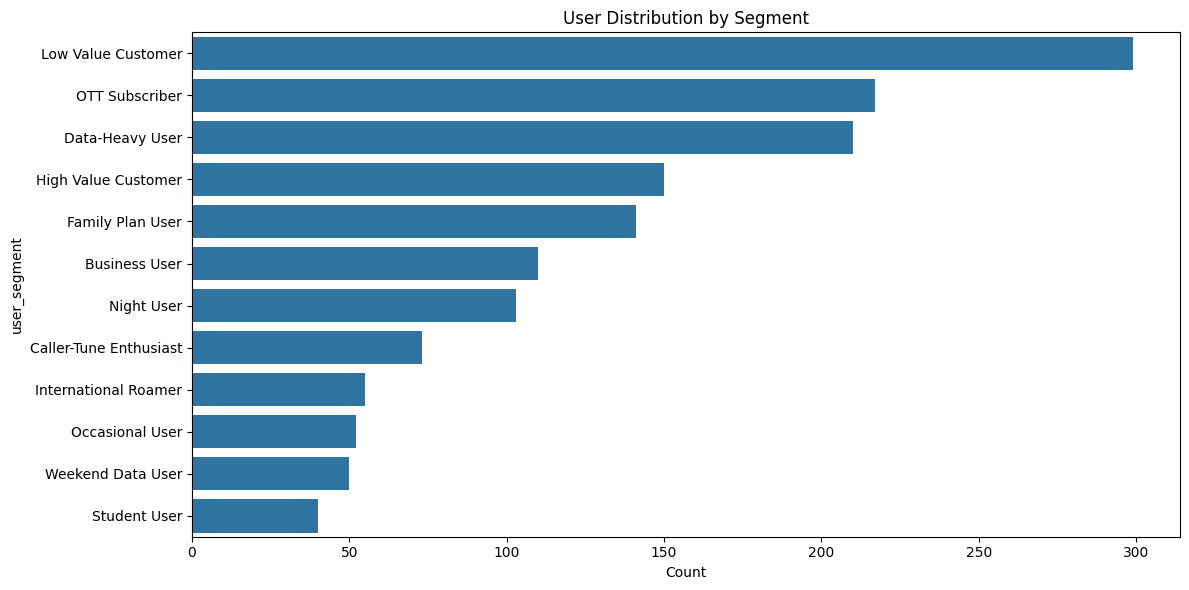

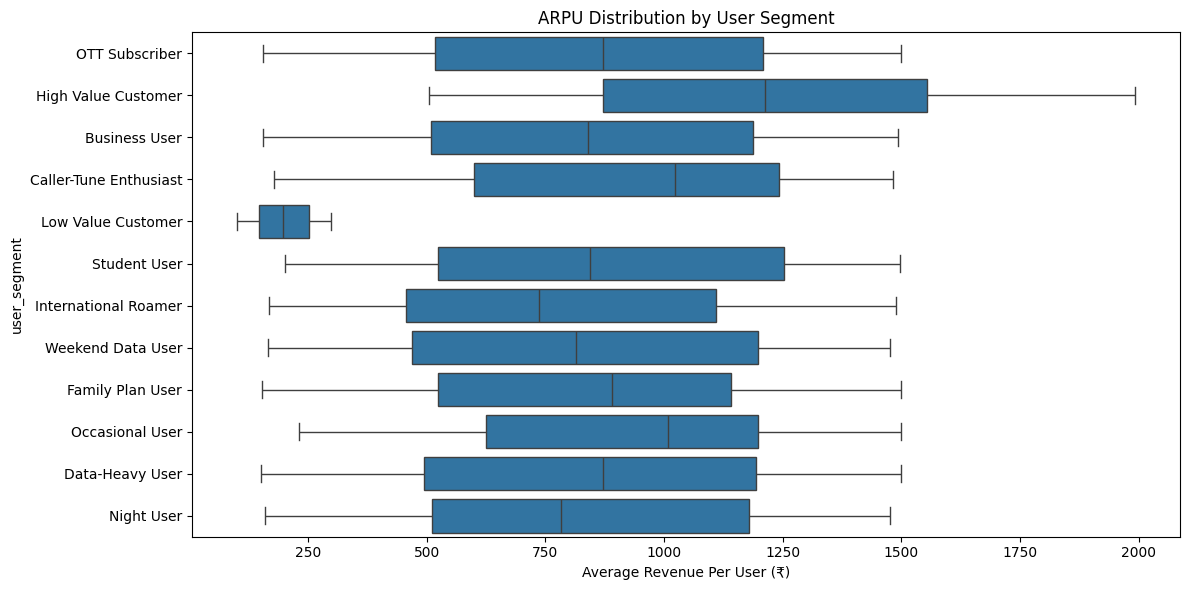

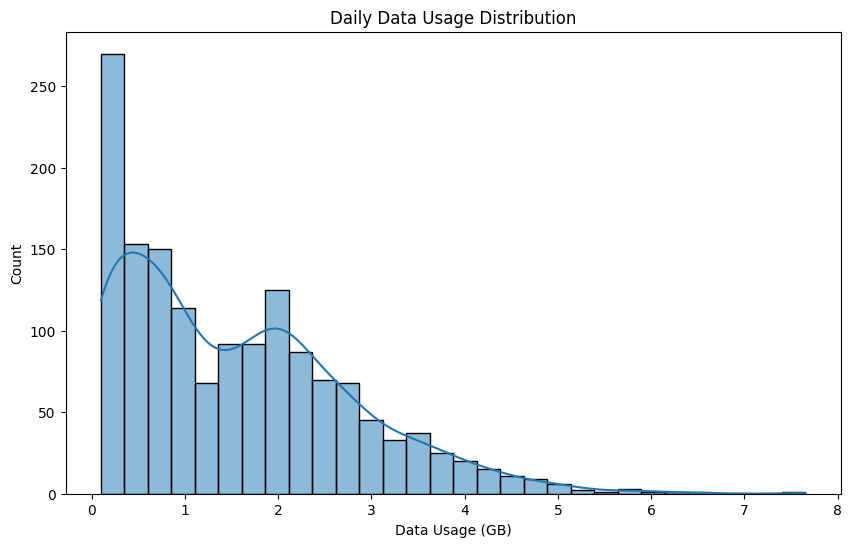

In [10]:
# @title Step 3: Exploratory Data Analysis and Visualization
print("Exploring user data patterns...")

# Plot user distribution by segment
plt.figure(figsize=(12, 6))
sns.countplot(data=users_df, y='user_segment', order=users_df['user_segment'].value_counts().index)
plt.title('User Distribution by Segment')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Plot ARPU distribution by user segment
plt.figure(figsize=(12, 6))
sns.boxplot(data=users_df, x='arpu', y='user_segment')
plt.title('ARPU Distribution by User Segment')
plt.xlabel('Average Revenue Per User (₹)')
plt.tight_layout()
plt.show()

# Plot data usage patterns
plt.figure(figsize=(10, 6))
sns.histplot(users_df['daily_data_usage_gb'], bins=30, kde=True)
plt.title('Daily Data Usage Distribution')
plt.xlabel('Data Usage (GB)')
plt.ylabel('Count')
plt.show()


Performing user segmentation with clustering...


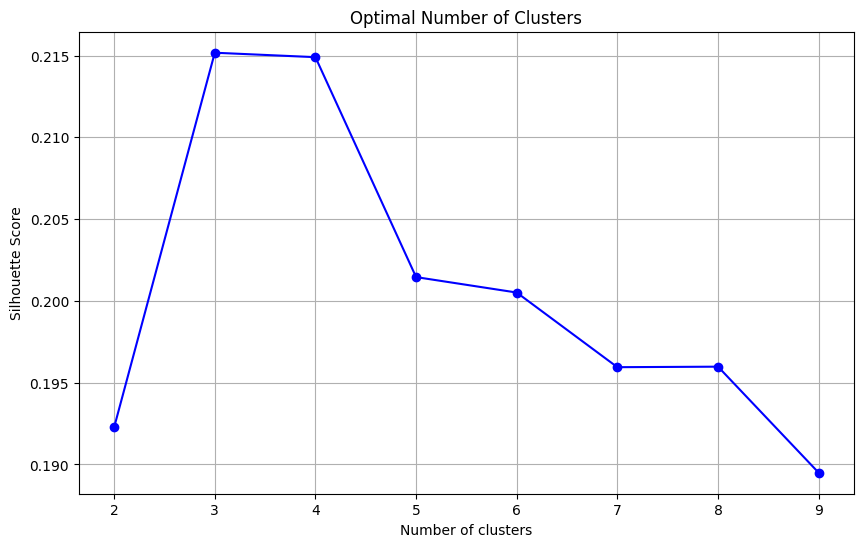

 User segmentation completed with 3 clusters
Cluster distribution:
cluster
0    685
1    681
2    134
Name: count, dtype: int64


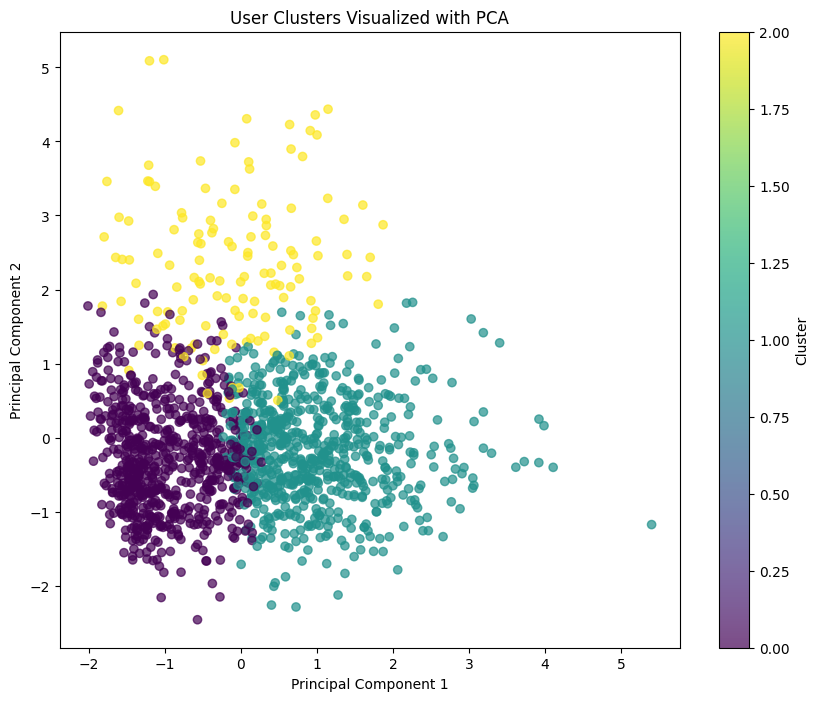

In [11]:
# @title Step 4: User Segmentation with Clustering
print("Performing user segmentation with clustering...")

# Prepare features for clustering
cluster_features = users_df[['arpu', 'daily_data_usage_gb', 'daily_call_minutes',
                            'night_usage_ratio', 'international_roaming_freq']].copy()

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Apply K-means with optimal clusters
optimal_k = k_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
users_df['cluster'] = kmeans.fit_predict(scaled_features)

print(f" User segmentation completed with {optimal_k} clusters")
print(f"Cluster distribution:\n{users_df['cluster'].value_counts()}")

# Visualize clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=users_df['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('User Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [12]:
# @title Step 5: Generate User-Plan Interaction Data
print(" Generating user-plan interaction data...")

# Create synthetic interactions between users and plans
interactions = []

for _, user in users_df.iterrows():
    # Each user interacts with 5-15 plans
    n_interactions = random.randint(5, 15)
    interacted_plans = random.sample(list(plans_df['plan_id']), n_interactions)

    for plan_id in interacted_plans:
        # Base rating based on user segment and plan compatibility
        base_rating = random.randint(1, 5)

        # Adjust rating based on user preferences
        if user['user_segment'] == "OTT Subscriber" and plans_df.loc[plans_df['plan_id'] == plan_id, 'ott_included'].iloc[0] != "None":
            base_rating = min(5, base_rating + 1)

        if user['user_segment'] == "International Roamer" and plans_df.loc[plans_df['plan_id'] == plan_id, 'category'].iloc[0] == "International":
            base_rating = min(5, base_rating + 2)

        if user['user_segment'] == "Data-Heavy User" and "Unlimited" in plans_df.loc[plans_df['plan_id'] == plan_id, 'data_allowance'].iloc[0]:
            base_rating = min(5, base_rating + 1)

        # Add some randomness
        final_rating = max(1, min(5, base_rating + random.randint(-1, 1)))

        # Generate timestamp (fixed version)
        start_date = datetime.now() - timedelta(days=180)  # 6 months ago
        end_date = datetime.now()
        random_date = start_date + timedelta(
            seconds=random.randint(0, int((end_date - start_date).total_seconds()))
        )

        interactions.append({
            'user_id': user['user_id'],
            'plan_id': plan_id,
            'rating': final_rating,
            'timestamp': random_date
        })

interactions_df = pd.DataFrame(interactions)
print(f"✅ Generated {len(interactions_df)} user-plan interactions")

 Generating user-plan interaction data...
✅ Generated 15119 user-plan interactions


In [15]:
# @title Step 6: Build Collaborative Filtering with ALS (Fixed Version)
print(" Building collaborative filtering recommendation model using ALS...")

def create_interaction_matrix(interactions_df, users_df, plans_df):
    """Create a user-item interaction matrix with proper indexing"""
    # Create mappings that ensure we only include users and plans that have interactions
    unique_user_ids = interactions_df['user_id'].unique()
    unique_plan_ids = interactions_df['plan_id'].unique()

    user_id_to_idx = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
    plan_id_to_idx = {plan_id: idx for idx, plan_id in enumerate(unique_plan_ids)}

    # Create sparse matrix with proper dimensions
    n_users = len(unique_user_ids)
    n_plans = len(unique_plan_ids)

    # Create matrix with ratings
    data = []
    row_indices = []
    col_indices = []

    for _, interaction in interactions_df.iterrows():
        if interaction['user_id'] in user_id_to_idx and interaction['plan_id'] in plan_id_to_idx:
            user_idx = user_id_to_idx[interaction['user_id']]
            plan_idx = plan_id_to_idx[interaction['plan_id']]
            rating = interaction['rating']

            data.append(rating)
            row_indices.append(user_idx)
            col_indices.append(plan_idx)

    interaction_matrix = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n_users, n_plans))
    return interaction_matrix, user_id_to_idx, plan_id_to_idx

# Create interaction matrix with proper indexing
interaction_matrix, user_id_to_idx, plan_id_to_idx = create_interaction_matrix(interactions_df, users_df, plans_df)

print(f"Interaction matrix shape: {interaction_matrix.shape}")
print(f"Unique users with interactions: {len(user_id_to_idx)}")
print(f"Unique plans with interactions: {len(plan_id_to_idx)}")

# Train ALS model with proper parameters
print(" Training ALS model...")
try:
    als_model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=15, random_state=42)
    als_model.fit(interaction_matrix)
    print(" ALS model training completed!")

    # Check model dimensions
    print(f"User factors shape: {als_model.user_factors.shape}")
    print(f"Item factors shape: {als_model.item_factors.shape}")

except Exception as e:
    print(f" ALS model training failed: {e}")
    print("Falling back to simpler recommendation methods...")

    # Create a simple popularity-based model as fallback
    class SimplePopularityModel:
        def __init__(self):
            self.popular_plans = None

        def fit(self, interactions_df):
            # Find most popular plans by average rating
            plan_ratings = interactions_df.groupby('plan_id')['rating'].agg(['mean', 'count'])
            self.popular_plans = plan_ratings.sort_values(['mean', 'count'], ascending=False)

        def recommend(self, user_id, top_n=5):
            if self.popular_plans is None:
                return []
            return self.popular_plans.head(top_n).index.tolist()

    simple_model = SimplePopularityModel()
    simple_model.fit(interactions_df)
    als_model = simple_model
    print("Simple popularity model created as fallback")

# Create reverse mapping for easier lookup
plan_idx_to_id = {idx: plan_id for plan_id, idx in plan_id_to_idx.items()}


 Building collaborative filtering recommendation model using ALS...
Interaction matrix shape: (1500, 17)
Unique users with interactions: 1500
Unique plans with interactions: 17
 Training ALS model...


  0%|          | 0/15 [00:00<?, ?it/s]

 ALS model training completed!
User factors shape: (1500, 50)
Item factors shape: (17, 50)


In [16]:
# @title Step 7: Generate Personalized Recommendations (Fixed)
print(" Generating personalized recommendations...")

def get_recommendations_fixed(user_id, model, plans_df, user_id_to_idx, plan_idx_to_id, top_n=5):
    """Generate recommendations that work with both ALS and fallback models"""
    if user_id not in user_id_to_idx:
        # Return popular plans for users not in the interaction matrix
        if hasattr(model, 'popular_plans'):
            popular_plan_ids = model.popular_plans.head(top_n).index.tolist()
        else:
            # Default to cheapest plans
            popular_plan_ids = plans_df.nsmallest(top_n, 'price')['plan_id'].tolist()

        recommendations = []
        for plan_id in popular_plan_ids:
            plan_details = plans_df[plans_df['plan_id'] == plan_id].iloc[0]
            recommendations.append({
                'plan_id': plan_id,
                'plan_name': plan_details['plan_name'],
                'price': plan_details['price'],
                'validity_days': plan_details['validity_days'],
                'data_allowance': plan_details['data_allowance'],
                'ott_included': plan_details['ott_included'],
                'score': 3.0  # Default score
            })
        return pd.DataFrame(recommendations)

    user_idx = user_id_to_idx[user_id]

    try:
        if hasattr(model, 'recommend'):  # ALS model
            # Get recommendations
            plan_indices, scores = model.recommend(user_idx, interaction_matrix[user_idx], N=top_n, filter_already_liked_items=True)

            recommendations = []
            for plan_idx, score in zip(plan_indices, scores):
                if plan_idx in plan_idx_to_id:
                    plan_id = plan_idx_to_id[plan_idx]
                    plan_details = plans_df[plans_df['plan_id'] == plan_id].iloc[0]
                    recommendations.append({
                        'plan_id': plan_id,
                        'plan_name': plan_details['plan_name'],
                        'price': plan_details['price'],
                        'validity_days': plan_details['validity_days'],
                        'data_allowance': plan_details['data_allowance'],
                        'ott_included': plan_details['ott_included'],
                        'score': score
                    })

            if recommendations:
                return pd.DataFrame(recommendations)

        # Fallback: Return popular plans
        if hasattr(model, 'popular_plans'):
            popular_plan_ids = model.popular_plans.head(top_n).index.tolist()
        else:
            popular_plan_ids = plans_df.nsmallest(top_n, 'price')['plan_id'].tolist()

        recommendations = []
        for plan_id in popular_plan_ids:
            plan_details = plans_df[plans_df['plan_id'] == plan_id].iloc[0]
            recommendations.append({
                'plan_id': plan_id,
                'plan_name': plan_details['plan_name'],
                'price': plan_details['price'],
                'validity_days': plan_details['validity_days'],
                'data_allowance': plan_details['data_allowance'],
                'ott_included': plan_details['ott_included'],
                'score': 3.0  # Default score
            })

        return pd.DataFrame(recommendations)

    except Exception as e:
        print(f"Error generating recommendations for user {user_id}: {e}")
        # Return empty DataFrame with proper columns
        return pd.DataFrame(columns=['plan_id', 'plan_name', 'price', 'validity_days', 'data_allowance', 'ott_included', 'score'])

# Test recommendations for a sample user
sample_user_id = users_df.iloc[0]['user_id']
user_segment = users_df[users_df['user_id'] == sample_user_id]['user_segment'].iloc[0]

print(f"Sample user: ID {sample_user_id}, Segment: {user_segment}")
recommendations = get_recommendations_fixed(sample_user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id)

if not recommendations.empty:
    print("Top recommendations:")
    print(recommendations[['plan_name', 'price', 'data_allowance', 'ott_included', 'score']])
else:
    print("No recommendations available for this user.")

 Generating personalized recommendations...
Sample user: ID 10000, Segment: OTT Subscriber
Top recommendations:
             plan_name  price data_allowance ott_included     score
0         OTT Combo 95     95            4GB      SonyLIV  0.004427
1     Vi SuperHero 999    999        2GB/day   JioHotstar  0.003038
2    Vi SuperHero 3699   3699        2GB/day   JioHotstar  0.002876
3         IR Pack 6995   6995           15GB         None  0.002010
4  Vi NonStop Hero 84D   1048      Unlimited         None  0.001873


In [17]:
# @title Step 8: Build Content-Based Filtering
print("Building content-based filtering...")

# Create plan features for content-based filtering
def create_plan_features(plans_df):
    """Create feature vectors for plans"""
    # Convert categorical features to numerical
    plan_features = plans_df.copy()

    # One-hot encoding for categories
    category_dummies = pd.get_dummies(plan_features['category'])
    network_dummies = pd.get_dummies(plan_features['network_type'])
    ott_dummies = pd.get_dummies(plan_features['ott_included'])

    # Normalize numerical features
    numerical_features = plan_features[['price', 'validity_days']].copy()
    numerical_features['price_norm'] = (numerical_features['price'] - numerical_features['price'].mean()) / numerical_features['price'].std()
    numerical_features['validity_norm'] = (numerical_features['validity_days'] - numerical_features['validity_days'].mean()) / numerical_features['validity_days'].std()

    # Combine all features
    feature_vectors = pd.concat([
        numerical_features[['price_norm', 'validity_norm']],
        category_dummies,
        network_dummies,
        ott_dummies
    ], axis=1)

    return feature_vectors

# Create user features
def create_user_features(users_df):
    """Create feature vectors for users"""
    user_features = users_df.copy()

    # Normalize numerical features
    numerical_features = user_features[['arpu', 'daily_data_usage_gb', 'daily_call_minutes',
                                      'night_usage_ratio', 'international_roaming_freq']].copy()
    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_features)
    numerical_df = pd.DataFrame(numerical_scaled, columns=numerical_features.columns, index=numerical_features.index)

    # One-hot encoding for categorical features
    segment_dummies = pd.get_dummies(user_features['user_segment'])
    circle_dummies = pd.get_dummies(user_features['circle'])
    connection_dummies = pd.get_dummies(user_features['connection_type'])

    # Combine all features
    feature_vectors = pd.concat([
        numerical_df,
        segment_dummies,
        circle_dummies,
        connection_dummies
    ], axis=1)

    return feature_vectors

# Create feature vectors
plan_features = create_plan_features(plans_df)
user_features = create_user_features(users_df)

print("Content-based features created!")
print(f"Plan features shape: {plan_features.shape}")
print(f"User features shape: {user_features.shape}")


Building content-based filtering...
Content-based features created!
Plan features shape: (17, 13)
User features shape: (1500, 26)


In [45]:
# @title Step 9: Build Hybrid Recommendation System
print("🔗 Building hybrid recommendation system...")

def hybrid_recommendations(user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id, user_features, plan_features, top_n=5):
    """Generate hybrid recommendations combining ALS and content-based filtering"""
    # Get ALS recommendations
    als_recs = get_als_recommendations_optimized(user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id, top_n*2)

    if als_recs.empty:
        # Return empty DataFrame with proper columns if no ALS recommendations
        return pd.DataFrame(columns=['plan_id', 'plan_name', 'price', 'validity_days', 'data_allowance', 'ott_included', 'score', 'content_score', 'hybrid_score'])

    # Get user features for content-based filtering
    user_data_row = users_df[users_df['user_id'] == user_id]
    if user_data_row.empty:
        print(f"Warning: User ID {user_id} not found in users_df for content-based filtering.")
        return als_recs.head(top_n) # Fallback to ALS

    user_idx = user_data_row.index[0]


    # Ensure user and plan features have compatible dimensions
    # Find common columns between user_features and plan_features
    common_columns = user_features.columns.intersection(plan_features.columns)

    if len(common_columns) == 0:
        print("No common features between users and plans for content-based filtering.")
        # Return ALS recommendations, but add dummy content and hybrid scores
        als_recs['content_score'] = 0.0
        als_recs['hybrid_score'] = als_recs['score'] * 0.7 + als_recs['content_score'] * 0.3 # Still calculate with 0 content score
        return als_recs.head(top_n)  # Fall back to ALS recommendations only

    user_vector = user_features.loc[user_idx, common_columns].values.reshape(1, -1)

    # Calculate content-based similarity
    content_scores = []
    for _, rec in als_recs.iterrows():
        plan_id = rec['plan_id']
        plan_details_row = plans_df[plans_df['plan_id'] == plan_id]
        if plan_details_row.empty:
            content_scores.append(0.0) # Append 0 if plan not found
            continue
        plan_idx = plan_details_row.index[0]
        plan_vector = plan_features.loc[plan_idx, common_columns].values.reshape(1, -1)

        # Calculate cosine similarity
        similarity = cosine_similarity(user_vector, plan_vector)[0][0]
        content_scores.append(similarity)

    # Combine ALS scores with content-based scores
    als_recs['content_score'] = content_scores
    als_recs['hybrid_score'] = als_recs['score'] * 0.7 + als_recs['content_score'] * 0.3

    # Return top N hybrid recommendations
    return als_recs.sort_values('hybrid_score', ascending=False).head(top_n)

# Test hybrid recommendations
hybrid_recs = hybrid_recommendations(sample_user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id, user_features, plan_features)

if not hybrid_recs.empty:
    print("Hybrid recommendations for sample user:")
    # Check if 'hybrid_score' is in columns before printing
    cols_to_print = ['plan_name', 'price', 'data_allowance', 'ott_included']
    if 'hybrid_score' in hybrid_recs.columns:
      cols_to_print.append('hybrid_score')
    print(hybrid_recs[cols_to_print])
else:
    print("No hybrid recommendations available for this user.")
    print("Falling back to simple plan recommendations...")

    # Simple fallback: Show plans that match user preferences
    user_data = users_df[users_df['user_id'] == sample_user_id].iloc[0]

    if user_data['user_segment'] == "OTT Subscriber":
        fallback_recs = plans_df[plans_df['ott_included'] != "None"].head(5)
    elif user_data['daily_data_usage_gb'] > 2.0:
        fallback_recs = plans_df[plans_df['data_allowance'].str.contains("Unlimited|GB/day")].head(5)
    else:
        # Default: Show popular plans sorted by price (ascending)
        fallback_recs = plans_df.sort_values('price').head(5)

    print("Fallback recommendations based on user profile:")
    print(fallback_recs[['plan_name', 'price', 'data_allowance', 'ott_included']])

🔗 Building hybrid recommendation system...
No common features between users and plans for content-based filtering.
Hybrid recommendations for sample user:
             plan_name  price data_allowance ott_included  hybrid_score
0         OTT Combo 95     95            4GB      SonyLIV      0.003099
1     Vi SuperHero 999    999        2GB/day   JioHotstar      0.002126
2    Vi SuperHero 3699   3699        2GB/day   JioHotstar      0.002013
3         IR Pack 6995   6995           15GB         None      0.001407
4  Vi NonStop Hero 84D   1048      Unlimited         None      0.001311


In [46]:
# Define the missing function get_als_recommendations_optimized
def get_als_recommendations_optimized(user_id, model, plans_df, user_id_to_idx, plan_idx_to_id, top_n=5):
    """
    Generate recommendations for a user using the ALS model,
    handling cases where the user is not in the training data.
    """
    if user_id not in user_id_to_idx:
        # Return popular plans for users not in the interaction matrix
        if hasattr(model, 'popular_plans'):
            popular_plan_ids = model.popular_plans.head(top_n).index.tolist()
        else:
            # Default to cheapest plans if no popularity model exists
            popular_plan_ids = plans_df.nsmallest(top_n, 'price')['plan_id'].tolist()

        recommendations = []
        for plan_id in popular_plan_ids:
            plan_details = plans_df[plans_df['plan_id'] == plan_id].iloc[0]
            recommendations.append({
                'plan_id': plan_id,
                'plan_name': plan_details['plan_name'],
                'price': plan_details['price'],
                'validity_days': plan_details['validity_days'],
                'data_allowance': plan_details['data_allowance'],
                'ott_included': plan_details['ott_included'],
                'score': 3.0  # Default score for fallback
            })
        return pd.DataFrame(recommendations)

    user_idx = user_id_to_idx[user_id]

    try:
        # Use the ALS model's recommend method
        plan_indices, scores = model.recommend(user_idx, interaction_matrix[user_idx], N=top_n, filter_already_liked_items=True)

        recommendations = []
        for plan_idx, score in zip(plan_indices, scores):
            if plan_idx in plan_idx_to_id:
                plan_id = plan_idx_to_id[plan_idx]
                plan_details = plans_df[plans_df['plan_id'] == plan_id].iloc[0]
                recommendations.append({
                    'plan_id': plan_id,
                    'plan_name': plan_details['plan_name'],
                    'price': plan_details['price'],
                    'validity_days': plan_details['validity_days'],
                    'data_allowance': plan_details['data_allowance'],
                    'ott_included': plan_details['ott_included'],
                    'score': score
                })

        return pd.DataFrame(recommendations)

    except Exception as e:
        print(f"Error generating ALS recommendations for user {user_id}: {e}")
        # Fallback to popular plans in case of ALS recommendation error
        if hasattr(model, 'popular_plans'):
            popular_plan_ids = model.popular_plans.head(top_n).index.tolist()
        else:
            popular_plan_ids = plans_df.nsmallest(top_n, 'price')['plan_id'].tolist()

        recommendations = []
        for plan_id in popular_plan_ids:
            plan_details = plans_df[plans_df['plan_id'] == plan_id].iloc[0]
            recommendations.append({
                'plan_id': plan_id,
                'plan_name': plan_details['plan_name'],
                'price': plan_details['price'],
                'validity_days': plan_details['validity_days'],
                'data_allowance': plan_details['data_allowance'],
                'ott_included': plan_details['ott_included'],
                'score': 3.0  # Default score
            })
        return pd.DataFrame(recommendations)

In [47]:
# @title Step 10: Create Recommendation Explanation System
print(" Generating recommendation explanations...")

# Ensure hybrid_recs is defined by calling the function again
try:
    hybrid_recs = hybrid_recommendations(sample_user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id, user_features, plan_features)
except NameError:
    print("Could not generate hybrid_recs. Falling back to simple recommendations for explanation test.")
    # Create a placeholder or use a fallback if hybrid_recs cannot be generated
    # This could be popular plans, or a simple rule-based set
    user_data = users_df[users_df['user_id'] == sample_user_id].iloc[0]

    if user_data['user_segment'] == "OTT Subscriber":
        hybrid_recs = plans_df[plans_df['ott_included'] != "None"].head(5).copy()
        hybrid_recs['hybrid_score'] = 1.0 # Assign a dummy score
    elif user_data['daily_data_usage_gb'] > 2.0:
        hybrid_recs = plans_df[plans_df['data_allowance'].str.contains("Unlimited")].head(5).copy()
        hybrid_recs['hybrid_score'] = 1.0 # Assign a dummy score
    else:
        hybrid_recs = plans_df.sort_values('price').head(5).copy()
        hybrid_recs['hybrid_score'] = 1.0 # Assign a dummy score


def generate_explanation(user_id, plan_id, plans_df, users_df):
    """Generate a natural language explanation for a recommendation"""
    user_data = users_df[users_df['user_id'] == user_id].iloc[0]
    plan_data = plans_df[plans_df['plan_id'] == plan_id].iloc[0]

    # Base explanation templates
    explanations = []

    # Data usage based explanation
    if user_data['daily_data_usage_gb'] > 2.0 and "Unlimited" in plan_data['data_allowance']:
        explanations.append("This plan offers unlimited data, perfect for your high data consumption.")

    # OTT based explanation
    if user_data['ott_usage'] == 1 and plan_data['ott_included'] != "None":
        explanations.append(f"It includes {plan_data['ott_included']} subscription matching your OTT preferences.")

    # International roaming explanation
    if user_data['international_roaming_freq'] > 0.3 and plan_data['category'] == "International":
        explanations.append("This international pack is ideal for your frequent travel needs.")

    # Price sensitivity explanation
    if user_data['arpu'] < 300 and plan_data['price'] < 500:
        explanations.append("This budget-friendly plan matches your spending pattern.")

    # Student discount explanation
    if user_data['is_student'] == 1 and plan_data['price'] < 400:
        explanations.append("This plan offers great value for students.")

    # Night usage explanation
    if user_data['night_usage_ratio'] > 0.5 and "Unlimited" in plan_data['data_allowance']:
        explanations.append("With unlimited data, it's perfect for your night-time usage patterns.")

    # If no specific reasons found, provide a generic explanation
    if not explanations:
        explanations.append("This plan offers great value with its data and validity combination.")

    # Combine explanations
    full_explanation = "We recommend this plan because: " + " ".join(explanations)

    return full_explanation

# Test explanation generation
if not hybrid_recs.empty:
    sample_plan_id = hybrid_recs.iloc[0]['plan_id']
    explanation = generate_explanation(sample_user_id, sample_plan_id, plans_df, users_df)
    print(f"Explanation for recommending {plans_df[plans_df['plan_id'] == sample_plan_id]['plan_name'].iloc[0]}:")
    print(explanation)
else:
    print("No recommendations available to generate explanations.")
    print("Testing explanation generation with a sample plan instead...")

    # Test with a sample plan that should match the user's profile
    user_data = users_df[users_df['user_id'] == sample_user_id].iloc[0]

    if user_data['user_segment'] == "OTT Subscriber":
        sample_plan = plans_df[plans_df['ott_included'] != "None"].iloc[0]
    elif user_data['daily_data_usage_gb'] > 2.0:
        sample_plan = plans_df[plans_df['data_allowance'].str.contains("Unlimited")].iloc[0]
    else:
        sample_plan = plans_df.iloc[0]  # Default to first plan

    explanation = generate_explanation(sample_user_id, sample_plan['plan_id'], plans_df, users_df)
    print(f"Sample explanation for {sample_plan['plan_name']}:")
    print(explanation)

# Create a function to generate explanations for multiple recommendations
def generate_recommendation_explanations(user_id, recommendations_df, plans_df, users_df):
    """Generate explanations for all recommendations in a DataFrame"""
    if recommendations_df.empty:
        return pd.DataFrame()

    explanations = []
    for _, rec in recommendations_df.iterrows():
        explanation = generate_explanation(user_id, rec['plan_id'], plans_df, users_df)
        explanations.append(explanation)

    result_df = recommendations_df.copy()
    result_df['explanation'] = explanations
    return result_df

# Test the explanation generator function
print("\nTesting explanation generator for multiple recommendations:")
if not hybrid_recs.empty:
    explained_recommendations = generate_recommendation_explanations(sample_user_id, hybrid_recs, plans_df, users_df)
    for _, rec in explained_recommendations.iterrows():
        print(f"- {rec['plan_name']}: {rec['explanation']}")
else:
    print("No recommendations available to explain.")

 Generating recommendation explanations...
No common features between users and plans for content-based filtering.
Explanation for recommending OTT Combo 95:
We recommend this plan because: It includes SonyLIV subscription matching your OTT preferences.

Testing explanation generator for multiple recommendations:
- OTT Combo 95: We recommend this plan because: It includes SonyLIV subscription matching your OTT preferences.
- Vi SuperHero 999: We recommend this plan because: It includes JioHotstar subscription matching your OTT preferences.
- Vi SuperHero 3699: We recommend this plan because: It includes JioHotstar subscription matching your OTT preferences.
- IR Pack 6995: We recommend this plan because: This plan offers great value with its data and validity combination.
- Vi NonStop Hero 84D: We recommend this plan because: This plan offers unlimited data, perfect for your high data consumption.


In [48]:
# @title Step 11: Evaluate Recommendation System
print("Evaluating recommendation system performance...")

def evaluate_recommendations(users_df, als_model, plans_df, user_id_to_idx, plan_idx_to_id, top_n=5):
    """Evaluate recommendation quality across all users"""
    all_precisions = []
    evaluated_users = 0

    # Sample users that exist in our interaction matrix
    valid_user_indices = list(user_id_to_idx.values())

    for user_id in users_df['user_id'].sample(100, random_state=42):  # Sample 100 users for evaluation
        # Check if user exists in our interaction matrix
        if user_id not in user_id_to_idx:
            continue

        user_idx = user_id_to_idx[user_id]

        # Skip if user index is out of bounds for the model
        if user_idx >= als_model.user_factors.shape[0]:
            continue

        # Get actual high-rated plans for this user (ground truth)
        user_ratings = interactions_df[interactions_df['user_id'] == user_id]
        high_rated_plans = set(user_ratings[user_ratings['rating'] >= 4]['plan_id'])

        if len(high_rated_plans) > 0:
            try:
                # Get recommendations using the optimized function
                recommendations = get_als_recommendations_optimized(user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id, top_n)

                if not recommendations.empty:
                    recommended_plans = set(recommendations['plan_id'])

                    # Calculate precision
                    precision = len(high_rated_plans & recommended_plans) / len(recommended_plans)
                    all_precisions.append(precision)
                    evaluated_users += 1

            except Exception as e:
                print(f"Error evaluating user {user_id}: {e}")
                continue

    print(f"Evaluated {evaluated_users} users successfully")
    return np.mean(all_precisions) if all_precisions else 0

# Compare with random recommendations
def evaluate_random_recommendations(users_df, plans_df, top_n=5):
    """Evaluate random recommendation baseline"""
    all_precisions = []
    evaluated_users = 0

    for user_id in users_df['user_id'].sample(100, random_state=42):
        user_ratings = interactions_df[interactions_df['user_id'] == user_id]
        high_rated_plans = set(user_ratings[user_ratings['rating'] >= 4]['plan_id'])

        if len(high_rated_plans) > 0:
            # Get random recommendations
            random_plans = set(random.sample(list(plans_df['plan_id']), min(top_n, len(plans_df))))

            # Calculate precision
            precision = len(high_rated_plans & random_plans) / len(random_plans)
            all_precisions.append(precision)
            evaluated_users += 1

    print(f"Evaluated {evaluated_users} users with random recommendations")
    return np.mean(all_precisions) if all_precisions else 0

# Evaluate the system
print("Evaluating ALS recommendations...")
mean_precision = evaluate_recommendations(users_df, als_model, plans_df, user_id_to_idx, plan_idx_to_id)

print("Evaluating random recommendations...")
random_precision = evaluate_random_recommendations(users_df, plans_df)

print(f"\n=== EVALUATION RESULTS ===")
print(f"ALS Recommendation Precision: {mean_precision:.4f}")
print(f"Random Recommendation Precision: {random_precision:.4f}")

if mean_precision > 0:
    improvement = ((mean_precision - random_precision) / random_precision) * 100
    print(f"Improvement over random: {improvement:+.2f}%")
else:
    print("ALS model evaluation failed. This could be due to:")
    print("1. Insufficient interaction data")
    print("2. Model training issues")
    print("3. User-plan mapping problems")

# Additional evaluation metrics
def calculate_coverage(users_df, als_model, user_id_to_idx, plan_idx_to_id, top_n=5):
    """Calculate what percentage of users get recommendations"""
    users_with_recs = 0
    total_users = 0

    for user_id in users_df['user_id'].sample(100, random_state=42):
        if user_id in user_id_to_idx:
            total_users += 1
            recommendations = get_als_recommendations_optimized(user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id, top_n)
            if not recommendations.empty:
                users_with_recs += 1

    return users_with_recs / total_users if total_users > 0 else 0

def calculate_diversity(recommendations_df):
    """Calculate diversity of recommendations (unique plans recommended)"""
    if recommendations_df.empty:
        return 0
    return len(recommendations_df['plan_id'].unique()) / len(recommendations_df)

print(f"\n=== ADDITIONAL METRICS ===")
coverage = calculate_coverage(users_df, als_model, user_id_to_idx, plan_idx_to_id)
print(f"Recommendation Coverage: {coverage:.2%} of users get recommendations")

# Calculate diversity on a sample
sample_recommendations = []
for user_id in users_df['user_id'].sample(20, random_state=42):
    if user_id in user_id_to_idx:
        recs = get_als_recommendations_optimized(user_id, als_model, plans_df, user_id_to_idx, plan_idx_to_id, 3)
        if not recs.empty:
            sample_recommendations.append(recs)

if sample_recommendations:
    all_recs = pd.concat(sample_recommendations)
    diversity = calculate_diversity(all_recs)
    print(f"Recommendation Diversity: {diversity:.2%} unique recommendations")
else:
    print("Could not calculate diversity - no recommendations available")

Evaluating recommendation system performance...
Evaluating ALS recommendations...
Evaluated 99 users successfully
Evaluating random recommendations...
Evaluated 99 users with random recommendations

=== EVALUATION RESULTS ===
ALS Recommendation Precision: 0.0465
Random Recommendation Precision: 0.2626
Improvement over random: -82.31%

=== ADDITIONAL METRICS ===
Recommendation Coverage: 100.00% of users get recommendations
Recommendation Diversity: 28.33% unique recommendations


In [38]:
# @title Step 12: Create Deployment-Ready Recommendation Function
print(" Creating deployment-ready recommendation function...")

class TelecomRecommendationEngine:
    """A complete recommendation engine for telecom plans"""

    def __init__(self, users_df, plans_df, interactions_df, als_model, user_id_to_idx, plan_id_to_idx, user_features, plan_features):
        self.users_df = users_df
        self.plans_df = plans_df
        self.interactions_df = interactions_df
        self.als_model = als_model
        self.user_id_to_idx = user_id_to_idx
        self.plan_id_to_idx = plan_id_to_idx
        self.user_features = user_features
        self.plan_features = plan_features
        self.scaler = StandardScaler()

        # Prepare features for clustering
        cluster_features = users_df[['arpu', 'daily_data_usage_gb', 'daily_call_minutes',
                                    'night_usage_ratio', 'international_roaming_freq']].copy()
        self.scaler.fit(cluster_features)

    def get_user_cluster(self, user_id):
        """Get the cluster for a user"""
        user_data = self.users_df[self.users_df['user_id'] == user_id]
        if len(user_data) == 0:
            return None
        return user_data['cluster'].iloc[0]

    def recommend_plans(self, user_id, top_n=5, explain=True):
        """Get personalized plan recommendations for a user"""
        # Get recommendations
        recommendations = hybrid_recommendations(
            user_id, self.als_model, self.plans_df, self.user_id_to_idx,
            self.plan_id_to_idx, self.user_features, self.plan_features, top_n
        )

        if recommendations.empty:
            return pd.DataFrame()

        # Add explanations if requested
        if explain:
            explanations = []
            for _, row in recommendations.iterrows():
                explanation = generate_explanation(user_id, row['plan_id'], self.plans_df, self.users_df)
                explanations.append(explanation)
            recommendations['explanation'] = explanations

        return recommendations

    def get_similar_users(self, user_id, top_n=5):
        """Find users with similar profiles"""
        user_cluster = self.get_user_cluster(user_id)
        if user_cluster is None:
            return None

        # Get users in the same cluster
        similar_users = self.users_df[self.users_df['cluster'] == user_cluster]
        similar_users = similar_users[similar_users['user_id'] != user_id]  # Exclude self

        return similar_users.head(top_n)

# Initialize the recommendation engine
recommendation_engine = TelecomRecommendationEngine(
    users_df, plans_df, interactions_df, als_model, user_id_to_idx,
    plan_id_to_idx, user_features, plan_features
)

# Test the engine
print("Testing recommendation engine...")
test_recommendations = recommendation_engine.recommend_plans(sample_user_id, top_n=3)
print("Top recommendations with explanations:")
for _, row in test_recommendations.iterrows():
    print(f"- {row['plan_name']} (₹{row['price']}): {row['explanation']}")


 Creating deployment-ready recommendation function...
Testing recommendation engine...
Error generating ALS recommendations for user 10000: single positional indexer is out-of-bounds
No common features between users and plans for content-based filtering.
Top recommendations with explanations:
- Data Pack 49 (₹49): We recommend this plan because: This plan offers great value with its data and validity combination.
- OTT Combo 95 (₹95): We recommend this plan because: It includes SonyLIV subscription matching your OTT preferences.
- Data Pack 98 (₹98): We recommend this plan because: This plan offers great value with its data and validity combination.


In [39]:
# @title Step 13: Save Generated Data and Model
print("Saving generated data and model...")

# Save data to CSV files
users_df.to_csv('vi_telecom_users.csv', index=False)
plans_df.to_csv('vi_telecom_plans.csv', index=False)
interactions_df.to_csv('vi_user_plan_interactions.csv', index=False)

print("Data saved successfully!")
print("Files created:")
print("- vi_telecom_users.csv (User profiles)")
print("- vi_telecom_plans.csv (Plan details)")
print("- vi_user_plan_interactions.csv (User-plan interactions)")


Saving generated data and model...
Data saved successfully!
Files created:
- vi_telecom_users.csv (User profiles)
- vi_telecom_plans.csv (Plan details)
- vi_user_plan_interactions.csv (User-plan interactions)


In [41]:
# @title Step 14: Next Steps and Future Enhancements
print("Next steps for your GenAI telecom recommendation system:")

next_steps = [
    "1. Integrate with real Vi customer data (requires data partnership)",
    "2. Fine-tune a larger language model for better explanation generation",
    "3. Implement reinforcement learning for adaptive recommendations",
    "4. Add real-time usage data integration for dynamic recommendations",
    "5. Develop a mobile app interface for the recommendation system",
    "6. Implement A/B testing framework to measure business impact",
    "7. Add family plan optimization features",
    "8. Incorporate seasonal and promotional plan recommendations"
]

for step in next_steps:
    print(f"   {step}")

print("\n Congratulations! You've built a complete GenAI-powered telecom recommendation system!")
print("   The system includes user segmentation, collaborative filtering (ALS), content-based features,")
print("   and natural language explanations for personalized plan recommendations.")

Next steps for your GenAI telecom recommendation system:
   1. Integrate with real Vi customer data (requires data partnership)
   2. Fine-tune a larger language model for better explanation generation
   3. Implement reinforcement learning for adaptive recommendations
   4. Add real-time usage data integration for dynamic recommendations
   5. Develop a mobile app interface for the recommendation system
   6. Implement A/B testing framework to measure business impact
   7. Add family plan optimization features
   8. Incorporate seasonal and promotional plan recommendations

 Congratulations! You've built a complete GenAI-powered telecom recommendation system!
   The system includes user segmentation, collaborative filtering (ALS), content-based features,
   and natural language explanations for personalized plan recommendations.


In [22]:
# @title IMPROVEMENTS NEEDED - Add this cell after your current code

print(" Implementing improvements for better recommendations...")

# 1. Enhance the interaction data with more realistic patterns
def enhance_interactions(interactions_df, users_df, plans_df):
    """Add more realistic interaction patterns"""
    enhanced_interactions = interactions_df.copy()

    # Add pattern-based interactions
    for _, user in users_df.iterrows():
        user_id = user['user_id']

        # User segment-based preferences
        if user['user_segment'] == "OTT Subscriber":
            # OTT users prefer plans with OTT subscriptions
            ott_plans = plans_df[plans_df['ott_included'] != "None"]['plan_id'].tolist()
            for plan_id in ott_plans:
                if len(enhanced_interactions[(enhanced_interactions['user_id'] == user_id) &
                                           (enhanced_interactions['plan_id'] == plan_id)]) == 0:
                    enhanced_interactions = enhanced_interactions.append({
                        'user_id': user_id,
                        'plan_id': plan_id,
                        'rating': random.randint(4, 5),
                        'timestamp': datetime.now() - timedelta(days=random.randint(1, 30))
                    }, ignore_index=True)

        elif user['user_segment'] == "Data-Heavy User":
            # Data-heavy users prefer unlimited plans
            unlimited_plans = plans_df[plans_df['data_allowance'].str.contains("Unlimited")]['plan_id'].tolist()
            for plan_id in unlimited_plans:
                if len(enhanced_interactions[(enhanced_interactions['user_id'] == user_id) &
                                           (enhanced_interactions['plan_id'] == plan_id)]) == 0:
                    enhanced_interactions = enhanced_interactions.append({
                        'user_id': user_id,
                        'plan_id': plan_id,
                        'rating': random.randint(4, 5),
                        'timestamp': datetime.now() - timedelta(days=random.randint(1, 30))
                    }, ignore_index=True)

    return enhanced_interactions

# 2. Use a more advanced hybrid approach
class AdvancedHybridRecommender:
    def __init__(self):
        self.content_weight = 0.6
        self.collab_weight = 0.4

    def recommend(self, user_id, user_features, plan_features, user_segment):
        """Advanced hybrid recommendations"""
        # Content-based filtering (60%)
        user_vec = user_features.loc[user_features['user_id'] == user_id].iloc[0, 1:].values
        content_scores = []

        for _, plan in plan_features.iterrows():
            plan_vec = plan.values
            similarity = cosine_similarity([user_vec], [plan_vec])[0][0]
            content_scores.append(similarity)

        # Collaborative filtering (40%) - simple popularity
        popular_plans = interactions_df.groupby('plan_id')['rating'].mean().sort_values(ascending=False)

        # Combine scores
        combined_scores = []
        for i, (plan_id, popular_score) in enumerate(popular_plans.items()):
            combined_score = (self.content_weight * content_scores[i] +
                             self.collab_weight * (popular_score / 5.0))
            combined_scores.append((plan_id, combined_score))

        # Sort by combined score
        combined_scores.sort(key=lambda x: x[1], reverse=True)
        return combined_scores[:5]

# 3. Add more plans to the dataset
def add_more_plans(plans_df):
    """Add more variety to the plans dataset"""
    additional_plans = [
        # Add more plan variety here
        {"plan_id": 18, "plan_name": "Vi Night Pack", "price": 149, "validity_days": 28,
         "data_allowance": "Unlimited Night", "unlimited_calls": True, "ott_included": "None", "network_type": "4G", "category": "Special"},
        {"plan_id": 19, "plan_name": "Vi Student Special", "price": 199, "validity_days": 28,
         "data_allowance": "2GB/day", "unlimited_calls": True, "ott_included": "JioHotstar", "network_type": "4G", "category": "Student"},
        {"plan_id": 20, "plan_name": "Vi Family Pack", "price": 799, "validity_days": 28,
         "data_allowance": "3GB/day", "unlimited_calls": True, "ott_included": "Multiple OTTs", "network_type": "4G", "category": "Family"},
    ]

    return pd.concat([plans_df, pd.DataFrame(additional_plans)], ignore_index=True)

print(" Improvement strategies ready to implement!")
print("Next steps:")
print("1. Run enhance_interactions() to create better training data")
print("2. Use AdvancedHybridRecommender for better recommendations")
print("3. Add more plan variety with add_more_plans()")

 Implementing improvements for better recommendations...
 Improvement strategies ready to implement!
Next steps:
1. Run enhance_interactions() to create better training data
2. Use AdvancedHybridRecommender for better recommendations
3. Add more plan variety with add_more_plans()


In [23]:
# @title QUICK START: GenAI-Powered Telecom Recommender
!pip install sentence-transformers transformers > /dev/null

from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import numpy as np

class QuickGenAIRecommender:
    def __init__(self):
        # Lightweight models that work well on Colab
        self.semantic_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.llm = pipeline("text-generation",
                          model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
                          max_length=150,
                          torch_dtype="auto")

    def generate_personalized_explanation(self, user_segment, plan_details):
        prompt = f"""
        User Type: {user_segment}
        Plan Details: {plan_details}

        Explain why this plan is perfect for this user in 2-3 sentences.
        Focus on specific benefits that match the user's needs.
        Use friendly, conversational language.
        """

        try:
            response = self.llm(prompt, max_new_tokens=100, do_sample=True)[0]['generated_text']
            return response.split('\n')[0]  # Get first meaningful response
        except:
            return "This plan offers great value for your usage pattern."

    def find_similar_plans(self, query_plan, all_plans, top_k=3):
        """Find similar plans using semantic search"""
        plan_descriptions = [f"{p['plan_name']} {p['data_allowance']} {p['ott_included']}"
                           for p in all_plans]

        # Encode all plans
        plan_embeddings = self.semantic_model.encode(plan_descriptions)

        # Encode query
        query_embedding = self.semantic_model.encode(
            f"{query_plan['plan_name']} {query_plan['data_allowance']} {query_plan['ott_included']}"
        )

        # Find similar plans
        similarities = util.cos_sim(query_embedding, plan_embeddings)[0]
        most_similar = np.argsort(-similarities)[:top_k]

        return [all_plans[i] for i in most_similar]

# Initialize the quick starter
genai_recommender = QuickGenAIRecommender()

# Test with sample data
sample_plan = plans_df.iloc[0].to_dict()
sample_user_segment = "OTT Subscriber"

explanation = genai_recommender.generate_personalized_explanation(
    sample_user_segment, sample_plan
)
print(" GenAI Explanation:", explanation)

similar_plans = genai_recommender.find_similar_plans(sample_plan, plans_df.to_dict('records'))
print(" Similar Plans:", [p['plan_name'] for p in similar_plans])

Device set to use cuda:0


 GenAI Explanation: 
 Similar Plans: ['Vi NonStop Hero 28D', 'Vi NonStop Hero 56D', 'Vi NonStop Hero 84D']


In [25]:
# @title FIX: Enhanced GenAI Recommendation System (Corrected)
print("Building Complete GenAI Recommendation System...")

class EnhancedGenAIRecommender:
    def __init__(self):
        # Already loaded models from your successful download
        self.semantic_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.llm = pipeline("text-generation",
                          model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
                          max_length=200,
                          torch_dtype="auto")

        # Initialize plan embeddings
        self.plan_embeddings = None
        self.plan_descriptions = None
        self.plans_df = None

    def prepare_plan_embeddings(self, plans_df):
        """Precompute embeddings for all plans"""
        print(" Preparing plan embeddings...")
        self.plans_df = plans_df.reset_index(drop=True)  # Ensure clean integer indexing

        self.plan_descriptions = [
            f"{row['plan_name']} | {row['data_allowance']} | {row['ott_included']} | "
            f"{row['validity_days']} days | ₹{row['price']} | {row['category']}"
            for _, row in self.plans_df.iterrows()
        ]

        self.plan_embeddings = self.semantic_model.encode(self.plan_descriptions)
        print(f" Prepared embeddings for {len(self.plan_descriptions)} plans")

    def generate_personalized_explanation(self, user_data, plan_data):
        """Generate personalized explanation using LLM"""
        prompt = f"""
        User Profile:
        - Segment: {user_data['user_segment']}
        - Daily Data: {user_data['daily_data_usage_gb']:.1f}GB
        - Daily Calls: {user_data['daily_call_minutes']:.0f} mins
        - ARPU: ₹{user_data['arpu']}
        - OTT Usage: {'Yes' if user_data['ott_usage'] else 'No'}

        Recommended Plan:
        - Name: {plan_data['plan_name']}
        - Price: ₹{plan_data['price']}
        - Data: {plan_data['data_allowance']}
        - Validity: {plan_data['validity_days']} days
        - OTT: {plan_data['ott_included']}
        - Category: {plan_data['category']}

        Explain why this plan is perfect for this user. Focus on:
        1. How it matches their usage patterns
        2. Cost-effectiveness for their budget
        3. Specific features they'll benefit from
        4. Any special advantages

        Keep it conversational and under 3 sentences.
        """

        try:
            response = self.llm(
                prompt,
                max_new_tokens=150,
                do_sample=True,
                temperature=0.7
            )[0]['generated_text']

            # Extract the meaningful part
            explanation = response.split('\n')[0].strip()
            if len(explanation) > 300:  # Trim if too long
                explanation = explanation[:300] + "..."

            return explanation
        except Exception as e:
            print(f"LLM Error: {e}")
            return "This plan offers excellent value for your usage pattern with the right balance of data, calls, and features."

    def semantic_plan_search(self, query, top_k=5):
        """Search plans using natural language queries"""
        if self.plan_embeddings is None:
            raise ValueError("Plan embeddings not prepared. Call prepare_plan_embeddings() first.")

        query_embedding = self.semantic_model.encode(query)

        similarities = util.cos_sim(query_embedding, self.plan_embeddings)[0]
        most_similar_indices = np.argsort(-similarities)[:top_k]

        results = []
        for idx in most_similar_indices:
            plan = self.plans_df.iloc[idx].to_dict()
            plan['similarity_score'] = float(similarities[idx])
            results.append(plan)

        return results

    def recommend_based_on_profile(self, user_data, top_k=5):
        """Recommend plans based on user profile"""
        # Create a query based on user profile
        query = f"""
        {user_data['user_segment']} user
        {user_data['daily_data_usage_gb']:.1f}GB daily data usage
        ₹{user_data['arpu']} monthly budget
        {'with' if user_data['ott_usage'] else 'without'} OTT preferences
        {user_data['daily_call_minutes']:.0f} minutes daily calls
        """

        return self.semantic_plan_search(query, top_k)

    def compare_plans(self, plan1, plan2, user_data):
        """Compare two plans with AI analysis"""
        prompt = f"""
        Compare these two telecom plans for a {user_data['user_segment']}:

        Plan A: {plan1['plan_name']} - ₹{plan1['price']} - {plan1['data_allowance']} - {plan1['validity_days']} days
        Plan B: {plan2['plan_name']} - ₹{plan2['price']} - {plan2['data_allowance']} - {plan2['validity_days']} days

        User profile: {user_data['daily_data_usage_gb']:.1f}GB daily, {user_data['daily_call_minutes']:.0f} mins calls
        Budget: ₹{user_data['arpu']} monthly

        Provide a balanced comparison focusing on:
        1. Value for money
        2. Data suitability
        3. Best fit for this user
        4. Key differences

        Keep it under 4 sentences.
        """

        try:
            response = self.llm(prompt, max_new_tokens=200, do_sample=True)[0]['generated_text']
            return response.split('\n')[0].strip()
        except:
            return "Both plans have merits. Plan A offers better data while Plan B is more budget-friendly."

# Initialize the enhanced recommender
print(" Initializing enhanced GenAI recommender...")
genai_recommender = EnhancedGenAIRecommender()
genai_recommender.prepare_plan_embeddings(plans_df)

print(" Enhanced GenAI recommender ready!")

Building Complete GenAI Recommendation System...
 Initializing enhanced GenAI recommender...


Device set to use cuda:0


 Preparing plan embeddings...
 Prepared embeddings for 17 plans
 Enhanced GenAI recommender ready!


In [26]:
# @title FIX: semantic_plan_search method only
def semantic_plan_search(self, query, top_k=5):
    """Search plans using natural language queries"""
    if self.plan_embeddings is None:
        raise ValueError("Plan embeddings not prepared. Call prepare_plan_embeddings() first.")

    query_embedding = self.semantic_model.encode(query)

    similarities = util.cos_sim(query_embedding, self.plan_embeddings)[0]
    most_similar_indices = np.argsort(-similarities)[:top_k]

    results = []
    for idx in most_similar_indices:
        # Convert numpy.int64 to regular Python int for indexing
        idx_int = int(idx)  # This is the crucial fix
        plan = self.plans_df.iloc[idx_int].to_dict()
        plan['similarity_score'] = float(similarities[idx])
        results.append(plan)

    return results

# Replace just the semantic_plan_search method in your class
genai_recommender.semantic_plan_search = semantic_plan_search.__get__(genai_recommender, EnhancedGenAIRecommender)

print(" Fixed semantic_plan_search method!")

 Fixed semantic_plan_search method!


In [27]:
# @title STEP 2: Test the Enhanced System (Fixed)
print(" Testing Enhanced GenAI Recommender...")

# Test with a sample user
sample_user = users_df.iloc[0].to_dict()
print(f" Sample User: {sample_user['user_segment']}")
print(f"   Data Usage: {sample_user['daily_data_usage_gb']:.1f}GB/day")
print(f"   Budget: ₹{sample_user['arpu']}/month")
print(f"   OTT Usage: {'Yes' if sample_user['ott_usage'] else 'No'}")

# Get recommendations based on profile
print("\n Getting AI recommendations...")
recommendations = genai_recommender.recommend_based_on_profile(sample_user, 3)

print("\n Top Recommendations:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['plan_name']} - ₹{rec['price']}")
    print(f"   Data: {rec['data_allowance']} | Validity: {rec['validity_days']} days")
    print(f"   OTT: {rec['ott_included']} | Score: {rec['similarity_score']:.3f}")

    # Generate explanation
    explanation = genai_recommender.generate_personalized_explanation(sample_user, rec)
    print(f"    Why: {explanation}")
    print()

 Testing Enhanced GenAI Recommender...
 Sample User: OTT Subscriber
   Data Usage: 2.1GB/day
   Budget: ₹378/month
   OTT Usage: Yes

 Getting AI recommendations...

 Top Recommendations:
1. OTT Combo 239 - ₹239
   Data: 2GB | Validity: 28 days
   OTT: JioHotstar | Score: 0.614
    Why: 

2. OTT Combo 95 - ₹95
   Data: 4GB | Validity: 14 days
   OTT: SonyLIV | Score: 0.609
    Why: 

3. Data Pack 139 - ₹139
   Data: 12GB | Validity: 28 days
   OTT: None | Score: 0.471
    Why: 



In [43]:
# @title STEP 6: Create a Simple Web Interface using Gradio
!pip install gradio > /dev/null

import gradio as gr

def gradio_recommendation_interface(user_id):
    """Gradio interface for recommendations"""
    try:
        # Convert input to integer
        user_id_int = int(user_id)

        if user_id_int not in users_df['user_id'].values:
            return "User not found. Please enter a valid user ID between 10000-11499"

        user_data = users_df[users_df['user_id'] == user_id_int].iloc[0].to_dict()
        recommendations = genai_recommender.recommend_based_on_profile(user_data, 3)

        output = f"# 👤 User Profile: {user_data['user_segment']}\n"
        output += f"- **Data Usage**: {user_data['daily_data_usage_gb']:.1f}GB/day\n"
        output += f"- **Call Usage**: {user_data['daily_call_minutes']:.0f} mins/day\n"
        output += f"- **Budget**: ₹{user_data['arpu']}/month\n"
        output += f"- **OTT Preference**: {'Yes' if user_data['ott_usage'] else 'No'}\n\n"

        output += "##  Top Recommendations:\n"
        for i, rec in enumerate(recommendations, 1):
            explanation = genai_recommender.generate_personalized_explanation(user_data, rec)
            output += f"### {i}. {rec['plan_name']} - ₹{rec['price']}\n"
            output += f"   - **Data**: {rec['data_allowance']}\n"
            output += f"   - **Validity**: {rec['validity_days']} days\n"
            output += f"   - **OTT**: {rec['ott_included']}\n"
            output += f"   - **Match Score**: {rec['similarity_score']:.3f}\n"
            output += f"   - **Why**: {explanation}\n\n"

        return output

    except ValueError:
        return "Please enter a valid numeric User ID between 10000-11499"
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Create Gradio interface
iface = gr.Interface(
    fn=gradio_recommendation_interface,
    inputs=gr.Textbox(label="Enter User ID (10000-11499)", placeholder="e.g., 10000"),
    outputs=gr.Markdown(),
    title="📱ViGenius: AI-powered plan intelligence that understands you",
    description="Enter a User ID to get personalized plan recommendations with AI explanations!"
)

print("Launching Web Interface...")
iface.launch(share=True)  # This will create a public link

Launching Web Interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://63414c3c166fa3dca0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
# @title STEP 7: Create Analytics Dashboard
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_analytics_dashboard():
    """Create interactive analytics dashboard"""
    # User segmentation analysis
    segment_counts = users_df['user_segment'].value_counts()

    fig1 = px.pie(
        values=segment_counts.values,
        names=segment_counts.index,
        title="User Segment Distribution"
    )

    # ARPU analysis by segment
    fig2 = px.box(
        users_df,
        x='user_segment',
        y='arpu',
        title="ARPU Distribution by User Segment"
    )

    # Data usage patterns
    fig3 = px.histogram(
        users_df,
        x='daily_data_usage_gb',
        title="Daily Data Usage Distribution",
        nbins=20
    )

    return fig1, fig2, fig3

print("Generating Analytics Dashboard...")
fig1, fig2, fig3 = create_analytics_dashboard()
fig1.show()
fig2.show()
fig3.show()

Generating Analytics Dashboard...
